In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    xgb_ok = True
except Exception as e:
    xgb_ok = False
    print("XGBoost not available. Install with: pip install xgboost")

# Reproducibility
RNG = 42
np.random.seed(RNG)


In [2]:
# Try common filenames from Kaggle/UCI sources
candidates = [
    "covtype.csv",           # single CSV (many Kaggle mirrors)
    "covtype.data",          # UCI raw (no header)
    "train.csv",             # Kaggle competition format
]

found = None
for p in candidates:
    if os.path.exists(p):
        found = p
        break

if found is None:
    raise FileNotFoundError(
        "Place the dataset in the working directory as 'covtype.csv' or 'train.csv' (Kaggle competition)."
    )

if found == "covtype.data":
    # UCI raw .data has no header; define columns as per dataset description
    # 10 continuous + 4 wilderness (binary) + 40 soil (binary) + Cover_Type
    cont_cols = [
        "Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
        "Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm",
        "Horizontal_Distance_To_Fire_Points"
    ]
    wild_cols = [f"Wilderness_Area{i}" for i in range(1,5)]
    soil_cols  = [f"Soil_Type{i}" for i in range(1,41)]
    cols = cont_cols + wild_cols + soil_cols + ["Cover_Type"]
    df = pd.read_csv(found, header=None, names=cols)
else:
    df = pd.read_csv(found)

# If Kaggle competition 'train.csv', keep it; if single 'covtype.csv', ensure target column name matches
if "Cover_Type" not in df.columns:
    # Some mirrors use lowercase or 'cover_type'
    ct_candidates = [c for c in df.columns if c.lower() == "cover_type".lower()]
    if ct_candidates:
        df = df.rename(columns={ct_candidates[0]: "Cover_Type"})
    else:
        raise ValueError("Target column 'Cover_Type' not found. Please verify the CSV schema.")

print("Shape:", df.shape)
df.head()


Shape: (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

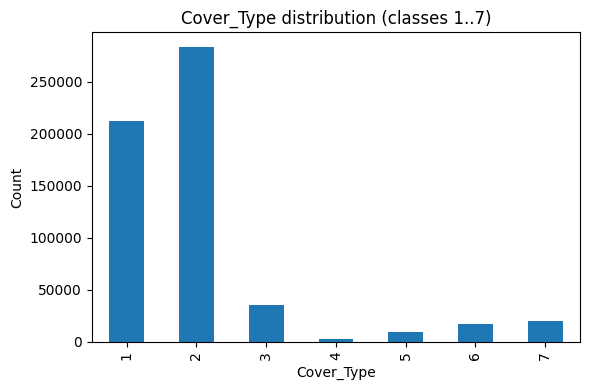

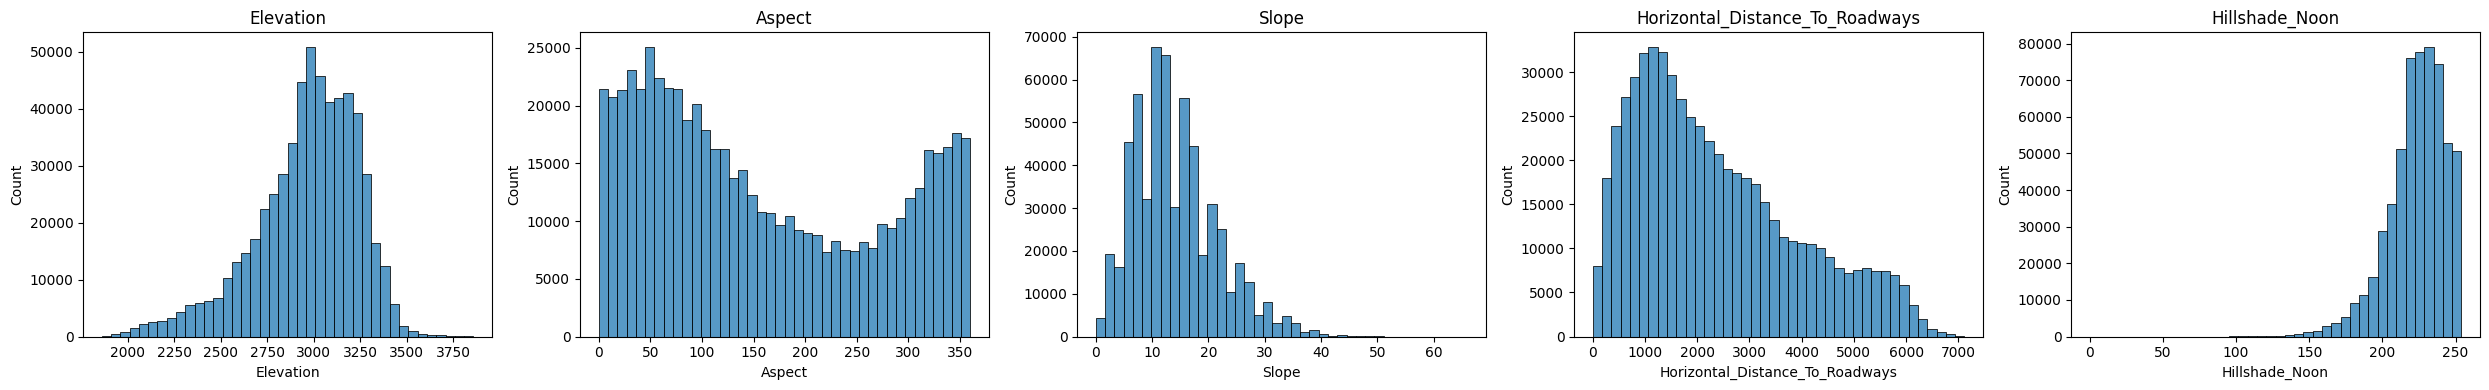

In [3]:
print(df.info())
print(df.describe().T.head(15))  # show first 15 features summary

# Class distribution
ax = df["Cover_Type"].value_counts().sort_index().plot(kind="bar", figsize=(6,4))
ax.set_title("Cover_Type distribution (classes 1..7)")
ax.set_xlabel("Cover_Type")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Identify continuous vs. binary columns (Wilderness/Soil are typically binary)
binary_like = [c for c in df.columns if c.startswith("Wilderness_Area") or c.startswith("Soil_Type")]
continuous = [c for c in df.columns if c not in binary_like + ["Cover_Type"]]

# Visualize a few key continuous features
sample_cont = ["Elevation","Aspect","Slope","Horizontal_Distance_To_Roadways","Hillshade_Noon"]
sample_cont = [c for c in sample_cont if c in continuous]

fig, axes = plt.subplots(1, len(sample_cont), figsize=(5*len(sample_cont), 4))
if len(sample_cont) == 1:
    axes = [axes]
for ax, col in zip(axes, sample_cont):
    sns.histplot(df[col], kde=False, ax=ax, bins=40)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [7]:
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]

# Stratified split to preserve class ratios
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG, stratify=y
)

X_train.shape, X_test.shape


((464809, 54), (116203, 54))

In [9]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

RandomForest Accuracy: 0.9542

Classification report (RF):
               precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.85      0.88       549
           5       0.95      0.78      0.86      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



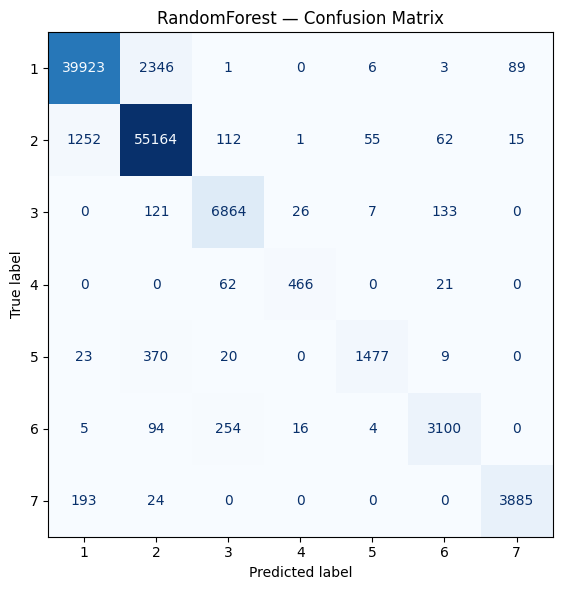

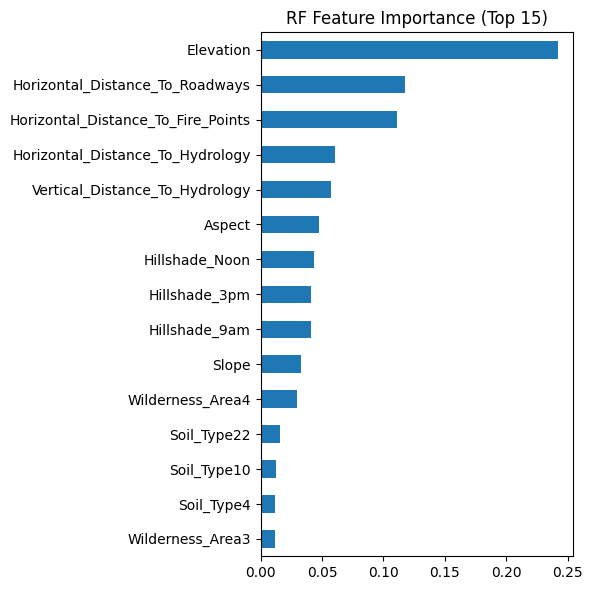

In [12]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RNG
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)
print(f"RandomForest Accuracy: {acc_rf:.4f}")
print("\nClassification report (RF):\n", classification_report(y_test, pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, pred_rf, labels=sorted(y.unique()))
disp = ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique()))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("RandomForest — Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature importances (top 15)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
ax = fi.plot(kind="barh", figsize=(6,6))
ax.invert_yaxis()
ax.set_title("RF Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


XGBoost Accuracy: 0.9356

Classification report (XGB):
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     42368
           1       0.93      0.95      0.94     56661
           2       0.95      0.96      0.95      7151
           3       0.92      0.86      0.89       549
           4       0.93      0.82      0.87      1899
           5       0.93      0.91      0.92      3473
           6       0.97      0.96      0.96      4102

    accuracy                           0.94    116203
   macro avg       0.94      0.91      0.92    116203
weighted avg       0.94      0.94      0.94    116203



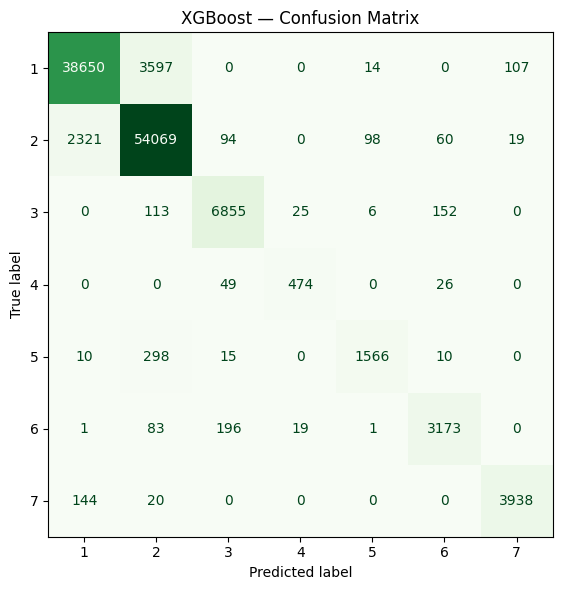

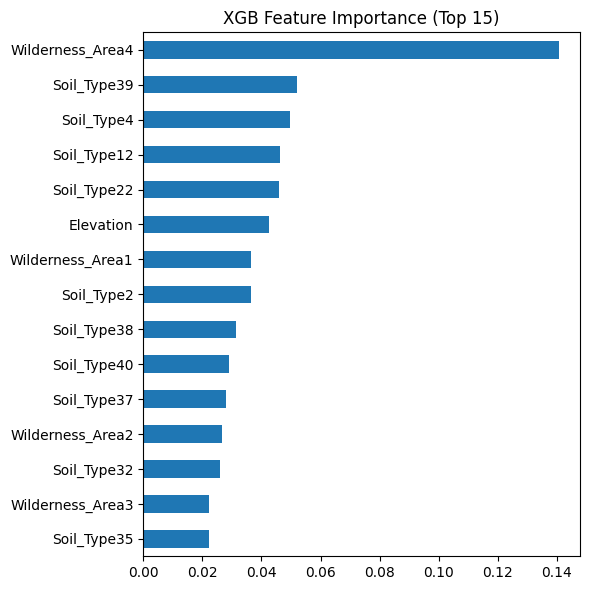

In [13]:
if xgb_ok:
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=7,   # 7 classes total
        tree_method="hist",
        random_state=RNG,
        n_jobs=-1
    )
    # Train with shifted labels (0..6)
    xgb.fit(X_train, y_train_xgb)

    pred_xgb = xgb.predict(X_test)

    # Evaluate against shifted test labels
    acc_xgb = accuracy_score(y_test_xgb, pred_xgb)
    print(f"XGBoost Accuracy: {acc_xgb:.4f}")
    print("\nClassification report (XGB):\n", classification_report(y_test_xgb, pred_xgb))

    # Confusion matrix (map back to 1..7 for readability)
    cm = confusion_matrix(y_test_xgb, pred_xgb, labels=range(7))
    disp = ConfusionMatrixDisplay(cm, display_labels=range(1,8))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Greens", values_format="d", colorbar=False)
    ax.set_title("XGBoost — Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Feature importances
    fi_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
    ax = fi_xgb.plot(kind="barh", figsize=(6,6))
    ax.invert_yaxis()
    ax.set_title("XGB Feature Importance (Top 15)")
    plt.tight_layout()
    plt.show()
else:
    print("XGBoost not installed — skipping.")


In [14]:
# Set SAMPLE_FRAC to e.g. 0.2 for ~20% of data; set to 1.0 to keep full
SAMPLE_FRAC = 0.25

if SAMPLE_FRAC < 1.0:
    Xs, _, ys, _ = train_test_split(X, y, train_size=SAMPLE_FRAC, random_state=RNG, stratify=y)
else:
    Xs, ys = X.copy(), y.copy()

print("Sampled shape:", Xs.shape)


Sampled shape: (145253, 54)


In [15]:
rf_base = RandomForestClassifier(n_jobs=-1, random_state=RNG)

rf_param_dist = {
    "n_estimators": [200, 400, 800],
    "max_depth": [None, 12, 18, 24],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring="accuracy",
    random_state=RNG,
    n_jobs=-1,
    verbose=1
)

Xs_train, Xs_val, ys_train, ys_val = train_test_split(
    Xs, ys, test_size=0.2, random_state=RNG, stratify=ys
)

rf_search.fit(Xs_train, ys_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV score:", rf_search.best_score_)

rf_tuned = rf_search.best_estimator_
pred_tuned = rf_tuned.predict(X_test)
print("Tuned RF on full test — Accuracy:", accuracy_score(y_test, pred_tuned))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 24}
Best RF CV score: 0.9108535137088863
Tuned RF on full test — Accuracy: 0.9244769928487216


In [18]:
# Re-label y to start from 0 instead of 1
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1


Baseline XGBoost Accuracy: 0.9356

Classification report (XGB):
               precision    recall  f1-score   support

           0       0.94      0.91      0.93     42368
           1       0.93      0.95      0.94     56661
           2       0.95      0.96      0.95      7151
           3       0.92      0.86      0.89       549
           4       0.93      0.82      0.87      1899
           5       0.93      0.91      0.92      3473
           6       0.97      0.96      0.96      4102

    accuracy                           0.94    116203
   macro avg       0.94      0.91      0.92    116203
weighted avg       0.94      0.94      0.94    116203



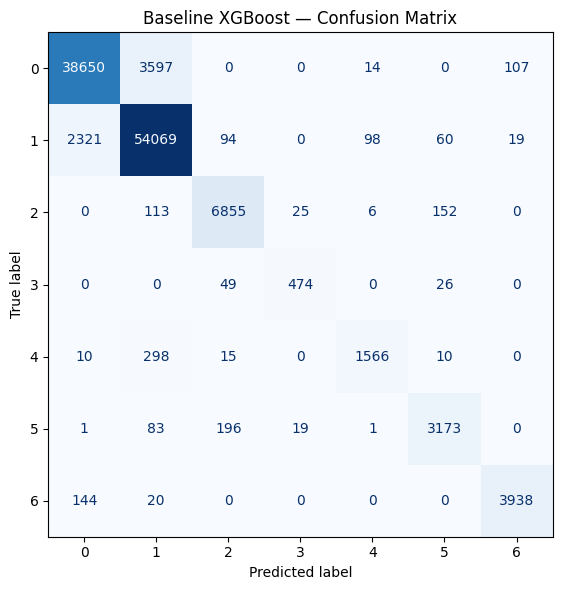

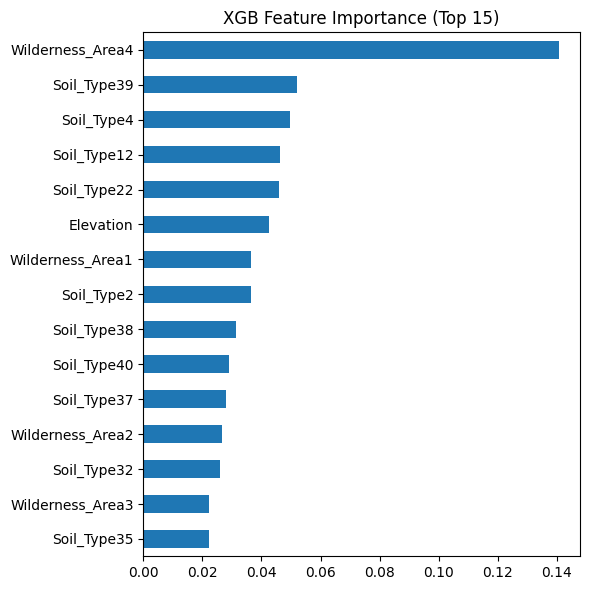

In [20]:
if xgb_ok:
    # Baseline XGBoost model
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(np.unique(y_train_xgb)),
        tree_method="hist",
        random_state=RNG,
        n_jobs=-1
    )

    # Fit on relabeled data
    xgb.fit(X_train, y_train_xgb)

    # Predict & evaluate
    pred_xgb = xgb.predict(X_test)
    acc_xgb = accuracy_score(y_test_xgb, pred_xgb)

    print(f"Baseline XGBoost Accuracy: {acc_xgb:.4f}")
    print("\nClassification report (XGB):\n", classification_report(y_test_xgb, pred_xgb))

    # Confusion matrix
    cm = confusion_matrix(y_test_xgb, pred_xgb, labels=np.unique(y_train_xgb))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_train_xgb))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title("Baseline XGBoost — Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Feature importance
    fi_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
    ax = fi_xgb.plot(kind="barh", figsize=(6,6))
    ax.invert_yaxis()
    ax.set_title("XGB Feature Importance (Top 15)")
    plt.tight_layout()
    plt.show()
else:
    print("XGBoost not installed — skipping.")


In [21]:
summary_rows = []

# RF baseline
summary_rows.append({
    "Model": "RandomForest (baseline)",
    "Test Accuracy": acc_rf
})

# XGB baseline
if xgb_ok:
    summary_rows.append({
        "Model": "XGBoost (baseline)",
        "Test Accuracy": acc_xgb
    })

# Tuned models
try:
    summary_rows.append({
        "Model": "RandomForest (tuned)",
        "Test Accuracy": accuracy_score(y_test, pred_tuned)
    })
except:
    pass

try:
    summary_rows.append({
        "Model": "XGBoost (tuned)",
        "Test Accuracy": accuracy_score(y_test, pred_xgb_tuned)
    })
except:
    pass

pd.DataFrame(summary_rows).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)


,Model,Test Accuracy
0,RandomForest (baseline),0.954184
1,XGBoost (baseline),0.935647
2,RandomForest (tuned),0.924477
